<a href="https://colab.research.google.com/github/sudhirk999/Cifar10-Transfer-Learning/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, HTML
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from keras import callbacks, optimizers
from keras.datasets import cifar10
from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 25
EPOCHS = 20
NUM_CLASSES = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.9

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=0.15,
                                                 stratify=np.array(y_train),
                                                 random_state=42)

In [0]:
from matplotlib.pyplot import imshow


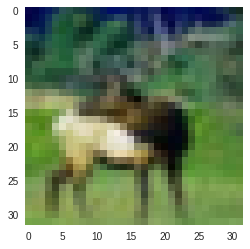

In [7]:
imshow(X_train[1])
plt.grid(None)

In [0]:
# Transform target labels into one hot encoded form

Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
# Since we are about to use VGG16 as a feature extractor, the minimum size
# of an image it takes is 48x48. We utilize `scipy to resize images to 
# required dimensions

X_train = np.array([sp.misc.imresize(x, (48,48)) for x in X_train])
X_val = np.array([sp.misc.imresize(x, (48,48)) for x in X_val])
X_test = np.array([sp.misc.imresize(x, (48,48)) for x in X_test])

In [10]:
X_train[1].shape

(48, 48, 3)

In [0]:
# MODEL PREPRATION

In [0]:
base_model = vgg.VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(48,48,3))

In [13]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [0]:
# Extract the last layer from the third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [0]:
# Add classification layer on top of it
x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [0]:
# Since our objective is to only train the custom classifier,
# we will than freeze the layers of VGG16

for layer in base_model.layers:
  layer.trainable = False

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [0]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=LEARNING_RATE),
             metrics=['accuracy'])

In [0]:
# DATA AUGMENTATION
# to help the model to overcome the limitation of a small dataset

In [0]:
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                  horizontal_flip=False)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [0]:

val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [0]:
# TRAIN THE MODEL

In [23]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/20
1700/1700 [==============================] - 821s 483ms/step - loss: 0.2648 - acc: 0.9071 - val_loss: 0.2076 - val_acc: 0.9223
Epoch 2/20
1700/1700 [==============================] - 820s 482ms/step - loss: 0.2292 - acc: 0.9178 - val_loss: 0.2024 - val_acc: 0.9240
Epoch 3/20
1700/1700 [==============================] - 820s 482ms/step - loss: 0.2218 - acc: 0.9204 - val_loss: 0.2032 - val_acc: 0.9269
Epoch 4/20
1700/1700 [==============================] - 820s 482ms/step - loss: 0.2203 - acc: 0.9215 - val_loss: 0.1843 - val_acc: 0.9313
Epoch 5/20
1700/1700 [==============================] - 821s 483ms/step - loss: 0.2185 - acc: 0.9222 - val_loss: 0.1902 - val_acc: 0.9300
Epoch 6/20
1700/1700 [==============================] - 824s 484ms/step - loss: 0.2212 - acc: 0.9219 - val_loss: 0.1990 - val_acc: 0.9276
Epoch 7/20
1700/1700 [==============================] - 824s 485ms/step - loss: 0.2197 - acc: 0.9225 - val_loss: 0.1903 - val_acc: 0.9308
Epoch 8/20
1700/1700 [============

In [0]:
model.save('saved_model.h5')

In [0]:
from keras.models import load_model
import cnn_utils as utils

In [0]:
new_model = load_model('saved_model.h5')

In [0]:
# Label Visualizer

label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

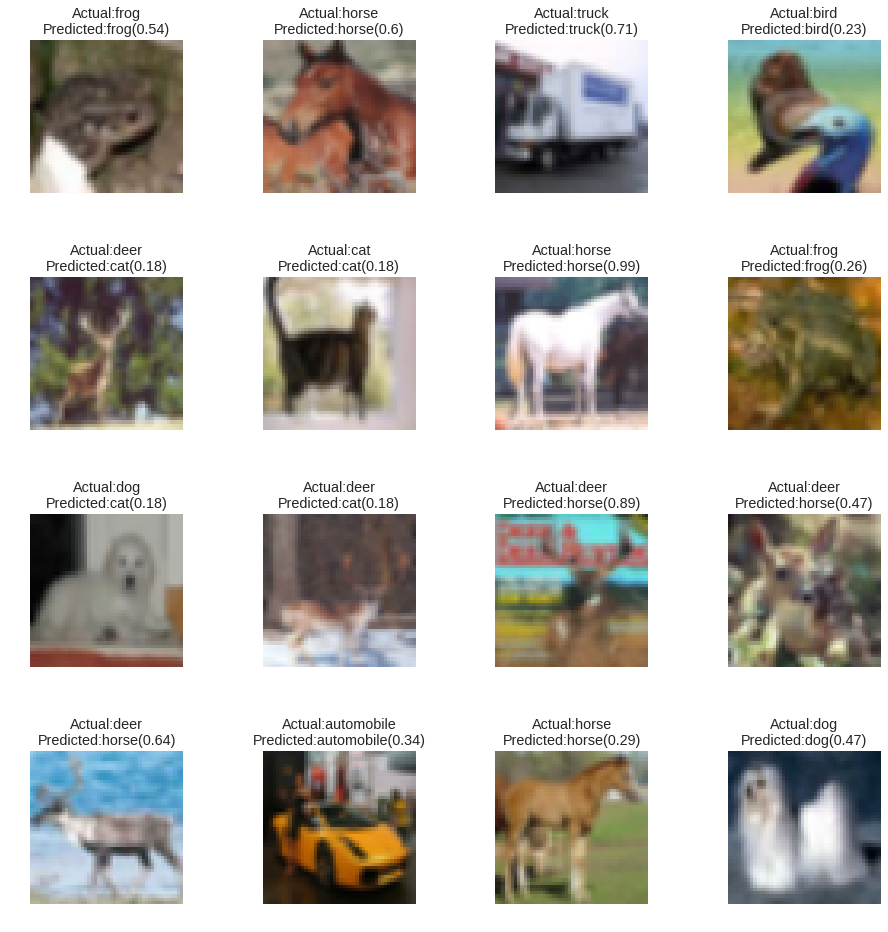

In [28]:
# Testing
utils.plot_predictions(model=model,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)